# ImmoEliza Project - Part 3: Regression 

# Step 1: Data Cleaning & Preprocessing

Handling of duplicates, missing values, '0', reduction of categories, encoding etc. before feature engineering

TODO: Remove Unused Encoding Methods

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

### Define DataCleaner class with various methods for data cleaning

In [9]:
class DataCleaner:
    def __init__(self, df: pd.DataFrame):
        """
        Initializes the DataCleaner class with a DataFrame.

        Args:
            df (pd.DataFrame): The input dataframe to be cleaned.
        """
        self.df = df

    def handle_missing_values(
        self, column: str, strategy: str = "fill", fill_value: str = "Unknown"
    ) -> pd.DataFrame:
        """
        Handles missing values for a specific column. By default, it fills missing values with a placeholder.

        Args:
            column (str): The column name to handle missing values.
            strategy (str): The strategy to handle missing values ('fill' or 'drop').
            fill_value (str): The value to use for filling missing values if strategy is 'fill'.
        """
        if strategy == "fill":
            self.df.loc[:, column] = self.df[column].fillna(fill_value)
        elif strategy == "drop":
            self.df.dropna(subset=[column], inplace=True)
        else:
            raise ValueError("Strategy must be 'fill' or 'drop'.")
        return self.df

    def convert_dtype(self, column: str, conv_type: str) -> pd.DataFrame:
        """
        Converts values in a column to another data type.

        Args:
            column (str): The column name to be converted.
            conv_type (str): The data type the values in the column should be converted to.

        Returns:
            pd.DataFrame: Pandas DataFrame with the converted column.
        """
        self.df[column] = self.df[column].astype(conv_type)

        return self.df

    def fill_missing_with_mode(
        self, column: str, strategy: str = "fill"
    ) -> pd.DataFrame:
        """
        Handles missing values for a specific column. By filling them with the mode.

        Args:
            column (str): The column name to handle missing values.
            strategy (str): The strategy to handle missing values ('fill' or 'drop').
        """
        if strategy == "fill":
            mode_value = self.df[column].mode()[0]
            self.df.loc[:, column] = self.df[column].fillna(mode_value)
        elif strategy == "drop":
            self.df.dropna(subset=[column], inplace=True)
        else:
            raise ValueError("Strategy must be 'fill' or 'drop'.")
        return self.df

    def fill_missing_by_group(
        self, column: str, group_column: str, agg_func: str = "median"
    ) -> pd.DataFrame:
        """
        Fills missing values in a column based on a group-specific statistic (e.g., median, mean).

        Args:
            column (str): The column with missing values to be filled.
            group_column (str): The column to group by (e.g., 'subtype_of_property').
            agg_func (str): The aggregation function to use ('median', 'mean', etc.).
        """
        if agg_func == "median":
            fill_values = self.df.groupby(group_column)[column].median()
        elif agg_func == "mean":
            fill_values = self.df.groupby(group_column)[column].mean()
        else:
            raise ValueError("Aggregation function must be 'median' or 'mean'.")

        # Fill missing values with the group-specific statistic
        self.df.loc[:, column] = self.df.apply(
            lambda row: (
                fill_values[row[group_column]]
                if pd.isnull(row[column])
                else row[column]
            ),
            axis=1,
        )
        return self.df

    def drop_outliers(
        self, column: str, lower_bound: float = None, upper_bound: float = None
    ) -> pd.DataFrame:
        """
        Drops rows where the values of a specified column are outside of the given bounds. If no bounds are given, calculates bounds based on IQR.

        Args:
            column (str): The column to filter outliers from.
            lower_bound (float): The lower bound for valid values.
            upper_bound (float): The upper bound for valid values.
        """

        # Calculate IQR for column
        Q1 = self.df[column].quantile(0.25)
        Q3 = self.df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Set default bounds if not provided
        lower_bound = lower_bound if lower_bound is not None else Q1 - 3 * IQR
        upper_bound = upper_bound if upper_bound is not None else Q3 + 3 * IQR

        # Drop rows outside the bounds
        self.df = self.df[self.df[column] >= lower_bound]
        self.df = self.df[self.df[column] <= upper_bound]

        return self.df

    def remove_substring(self, column: str, substring: str) -> pd.DataFrame:
        """
        Removes a specified substring from all values in a given column.

        Args:
            column (str): The column from which to remove the substring.
            substring (str): Substring to be removed.

        Returns:
            pd.DataFrame: The dataframe with the substring removed from the column.
        """
        # Replace occurrences of the substring with an empty string
        self.df.loc[:, column] = self.df[column].str.replace(substring, "", regex=False)

        return self.df

    def binarize_column(self, column: str, threshold: float = 0) -> pd.DataFrame:
        """
        Converts a specified column to binary values based on a threshold.
        Values greater than the threshold are set to 1, otherwise 0.

        Args:
            column: The column to binarize.
            threshold: The threshold to determine binary classification.
        """
        self.df.loc[:, column] = (self.df[column] > threshold).astype(int)
        return self.df

    def get_cleaned_df(self) -> pd.DataFrame:
        """
        Returns the cleaned dataframe.

        Returns:
            pd.DataFrame: The cleaned dataframe.
        """
        return self.df

### Define DataEncoder class with various methods for data encoding

In [10]:
class DataEncoder:
    """
    Class with methods to perform different form of data encoding.
    """

    def __init__(self, df: pd.DataFrame):
        """
        Initializes the DataEncoder class with a DataFrame.

        Args:
            df (pd.DataFrame): The input dataframe to be encoded.
        """
        self.df = df

    def standardize_categories(self, column: str, mapping: dict) -> pd.DataFrame:
        """
        Standardizes categorical values based on a given mapping.

        Args:
            column (str): The column to standardize.
            mapping (dict): A dictionary that maps old values to new values.
        """
        self.df.loc[:, column] = self.df.loc[:, column].map(mapping)
        return self.df

    def manual_mapping(self, column: str, mapping: dict) -> pd.DataFrame:
        """
        Applies manual mapping to a specified column using the provided dictionary.

        Args:
            column (str): The column to map.
            mapping (dict): A dictionary defining the mapping of the column's values.
        """
        # Ensure the column exists
        if column not in self.df.columns:
            raise KeyError(f"Column '{column}' not found in DataFrame.")
        # Apply the mapping
        self.df.loc[:, column] = self.df.loc[:, column].map(mapping)
        return self.df

    def encode_onehot(self, column: str) -> pd.DataFrame:
        """
        Encodes a categorical column using one-hot encoding.

        Args:
            column (str): The column to encode.

        Returns:
            pd.DataFrame: The original dataframe with new one-hot encoded columns.
        """
        onehot_encoder = OneHotEncoder(sparse=False)
        encoded_data = onehot_encoder.fit_transform(self.df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.categories_[0])
        encoded_df = encoded_df.astype(int)  # Convert boolean to integers
        self.df = pd.concat([self.df, encoded_df], axis=1)
        self.df.drop(
            columns=[column], inplace=True
        )  # Drop original column after encoding
        return self.df

    def encode_dummy(self, column: str, prefix: str = "") -> pd.DataFrame:
        """
        Encodes a categorical column using dummy encoding.

        Args:
            column (str): The column to encode.
            prefix (str): The prefix to add to the new column names.

        Returns:
            pd.DataFrame: The original dataframe with dummy encoded columns.
        """
        dummy_df = pd.get_dummies(
            self.df[column], drop_first=True, prefix=prefix
        )  # avoids multicollinearity
        dummy_df = dummy_df.astype(int)  # Convert boolean columns to integers
        self.df = pd.concat([self.df, dummy_df], axis=1)
        self.df.drop(
            columns=[column], inplace=True
        )  # Drop original column after encoding
        return self.df

    def get_encoded_df(self) -> pd.DataFrame:
        """
        Returns the dataframe with encoded categorical variables.

        Returns:
            pd.DataFrame: The dataframe with encoded columns.
        """
        return self.df

### Import dataset

In [14]:
import pandas as pd

df = pd.read_csv("./data/raw_data.csv")

### Handle Missing Values & Outliers, etc.

In [15]:
# Initialize DataCleaner instance
cleaner = DataCleaner(df)

# Drop missing values in 'price' column
df_cleaned = cleaner.handle_missing_values("price", strategy="drop")

# Fill missing 'facade_number' based on median per 'subtype_of_property'
df_cleaned = cleaner.fill_missing_by_group(
    "facade_number", group_column="subtype_of_property", agg_func="median"
)

# Drop outliers in price (IQR), 'living_area' (<12), 'facade_number' (>6), bedroom_nr (>24) -> since compared to other values of these data points, these entries don't seem realistic
df_cleaned = cleaner.drop_outliers("price")
df_cleaned = cleaner.drop_outliers("living_area", lower_bound=12)
df_cleaned = cleaner.drop_outliers("facade_number", upper_bound=6.0)
df_cleaned = cleaner.drop_outliers("bedroom_nr", upper_bound=24)

# Remove substring 'unit' from "subtype_of_property"
df_cleaned = cleaner.remove_substring("subtype_of_property", " unit")

# Fill missing 'building_condition' with mode
df_cleaned = cleaner.fill_missing_with_mode("building_condition", strategy="fill")

# Change 'terrace' to binary (if value: 1, if not, 0)
df_cleaned = cleaner.binarize_column("terrace", threshold=0)

# Get cleaned dataframe
df_cleaned = cleaner.get_cleaned_df()

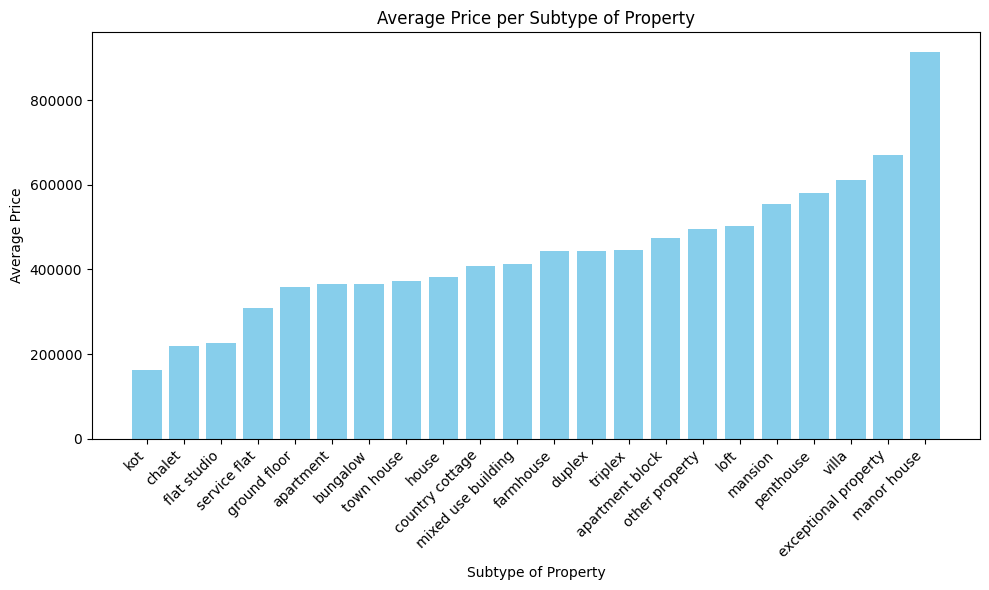

In [19]:
# Calculate average price per subtype of property

import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Step 1: Group by 'subtype_of_property' and calculate the average 'price'
average_price = (
    df_cleaned.groupby("subtype_of_property")["price"]
    .mean()
    .reset_index()
    .sort_values(by="price")
)

# Step 2: Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(average_price["subtype_of_property"], average_price["price"], color="skyblue")
plt.xlabel("Subtype of Property")
plt.ylabel("Average Price")
plt.title("Average Price per Subtype of Property")
plt.xticks(rotation=45, ha="right")  # Rotate x labels if needed
plt.tight_layout()
plt.show()

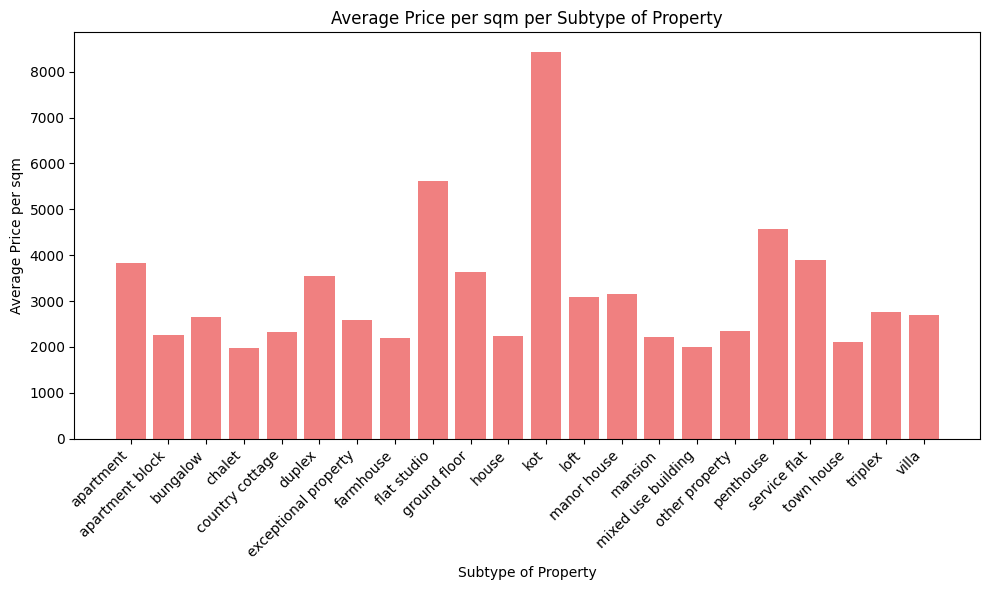

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Step 1: Calculate price per square meter
df_cleaned["price_per_sqm"] = df_cleaned["price"] / df_cleaned["living_area"]

# Step 2: Group by 'subtype_of_property' and calculate the average 'price_per_sqm'
average_price_per_sqm = (
    df_cleaned.groupby("subtype_of_property")["price_per_sqm"].mean().reset_index()
)

# Step 3: Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    average_price_per_sqm["subtype_of_property"],
    average_price_per_sqm["price_per_sqm"],
    color="lightcoral",
)
plt.xlabel("Subtype of Property")
plt.ylabel("Average Price per sqm")
plt.title("Average Price per sqm per Subtype of Property")
plt.xticks(rotation=45, ha="right")  # Rotate x labels if needed
plt.tight_layout()
plt.show()

### Handle Categorical Data

In [ ]:
# Initialize DataEncoder instance
encoder = DataEncoder(df_cleaned)

# Data Encoding: Standardize 'equipped_kitchen' categories
df_encoded = encoder.standardize_categories(
    "equipped_kitchen",
    {
        "installed": "installed",
        "semi equipped": "semi equipped",
        "hyper equipped": "hyper equipped",
        "not installed": "not installed",
        "usa installed": "installed",
        "usa hyper equipped": "hyper equipped",
        "usa semi equipped": "semi equipped",
        "usa uninstalled": "not installed",
        "0": "not installed",
    },
)

# Apply manual mapping to "equipped_kitchen" column
kitchen_mapping = {
    "not installed": 0,
    "semi equipped": 1,
    "installed": 2,
    "hyper equipped": 3,
}

df_encoded = encoder.manual_mapping("equipped_kitchen", kitchen_mapping)

# Apply dummy encoding to equipped kitchen
# df_encoded = encoder.encode_dummy('equipped_kitchen', prefix='kitchen')

# Apply manual mapping to "building_condition" column -> start at 1, since 0 reserved for 'not present'
condition_mapping = {
    "as new": 6,
    "just renovated": 5,
    "good": 4,
    "to be done up": 3,
    "to renovate": 2,
    "to restore": 1,
}

df_encoded = encoder.manual_mapping("building_condition", condition_mapping)

# Apply dummy encoding to building condition
# df_encoded = encoder.encode_dummy('building_condition', prefix='condition')

# Apply manual mapping to "subtype_of_property" column to reduce categories

subtype_categories = {
    "kot": "apartment",
    "chalet": "house",
    "flat studio": "apartment",
    "service flat": "apartment",
    "bungalow": "house",
    "town house": "house",
    "ground floor": "apartment",
    "apartment": "apartment",
    "house": "house",
    "mixed use building": "mixed use building",
    "triplex": "house",
    "farmhouse": "mixed use building",
    "loft": "luxury",
    "duplex": "house",
    "apartment block": "other",
    "country cottage": "house",
    "penthouse": "luxury",
    "mansion": "luxury",
    "other property": "other",
    "villa": "luxury",
    "exceptional property": "luxury",
    "manor house": "luxury",
    "castle": "luxury",
}

df_encoded = encoder.manual_mapping("subtype_of_property", subtype_categories)

# Apply manual mapping to reduced categories in "subtypes of property"

subtype_mapping = {
    "apartment": 1,
    "house": 2,
    "mixed use building": 3,
    "other": 4,
    "luxury": 5,
}

df_encoded = encoder.manual_mapping("subtype_of_property", subtype_mapping)

# Apply dummy encoding to subtype
# df_encoded = encoder.encode_dummy('subtype_of_property', prefix='subtype')

# Get final encoded dataframe
df_encoded = encoder.get_encoded_df()

In [7]:
df_encoded.isna().sum()

zip_code               0
commune                0
province               0
type_of_property       0
subtype_of_property    0
price                  0
building_condition     0
facade_number          0
living_area            0
equipped_kitchen       0
bedroom_nr             0
swimming_pool          0
furnished              0
open_fire              0
terrace                0
garden                 0
plot_surface           0
dtype: int64

In [6]:
# Export final dataframe
df_encoded.to_csv("./data/1_cleaned_data.csv", index=False)